In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
matplotlib.style.use('ggplot')
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [3]:
data = pd.read_csv('data.csv')
data.shape

(6000, 39)

In [4]:
X = data.drop('Grant.Status', 1)
y = data['Grant.Status']

In [5]:
data.head()

,Grant.Status,Sponsor.Code,Grant.Category.Code,Contract.Value.Band...see.note.A,RFCD.Code.1,RFCD.Percentage.1,RFCD.Code.2,RFCD.Percentage.2,RFCD.Code.3,RFCD.Percentage.3,...,Dept.No..1,Faculty.No..1,With.PHD.1,No..of.Years.in.Uni.at.Time.of.Grant.1,Number.of.Successful.Grant.1,Number.of.Unsuccessful.Grant.1,A..1,A.1,B.1,C.1
0,1,21A,50A,A,230202.0,50.0,230203.0,30.0,230204.0,20.0,...,3098.0,31.0,Yes,>=0 to 5,2.0,0.0,0.0,4.0,2.0,0.0
1,1,4D,10A,D,320801.0,100.0,0.0,0.0,0.0,0.0,...,2553.0,25.0,Yes,>=0 to 5,3.0,1.0,0.0,2.0,0.0,0.0
2,0,NaN,NaN,NaN,320602.0,50.0,321004.0,30.0,321015.0,20.0,...,2813.0,25.0,NaN,Less than 0,1.0,5.0,0.0,7.0,2.0,0.0
3,0,51C,20C,A,291503.0,60.0,321402.0,40.0,0.0,0.0,...,2553.0,25.0,NaN,more than 15,2.0,1.0,5.0,6.0,9.0,1.0
4,0,24D,30B,NaN,380107.0,100.0,0.0,0.0,0.0,0.0,...,2923.0,25.0,NaN,Less than 0,0.0,2.0,0.0,0.0,0.0,0.0


In [6]:
numeric_cols = ['RFCD.Percentage.1', 'RFCD.Percentage.2', 'RFCD.Percentage.3', 
                'RFCD.Percentage.4', 'RFCD.Percentage.5',
                'SEO.Percentage.1', 'SEO.Percentage.2', 'SEO.Percentage.3',
                'SEO.Percentage.4', 'SEO.Percentage.5',
                'Year.of.Birth.1', 'Number.of.Successful.Grant.1', 'Number.of.Unsuccessful.Grant.1']
categorical_cols = list(set(X.columns.values.tolist()) - set(numeric_cols))

In [7]:
data.dropna().shape

(213, 39)

In [8]:
def calculate_means(numeric_data):
    means = np.zeros(numeric_data.shape[1])
    for j in range(numeric_data.shape[1]):
        to_sum = numeric_data.iloc[:,j]
        indices = np.nonzero(~numeric_data.iloc[:,j].isnull())[0]
        correction = np.amax(to_sum[indices])
        to_sum /= correction
        for i in indices:
            means[j] += to_sum[i]
        means[j] /= indices.size
        means[j] *= correction
    return pd.Series(means, numeric_data.columns)

In [9]:
X_real_mean = X[numeric_cols].fillna(value = calculate_means(X[numeric_cols]))

In [10]:
X_real_zeros = X[numeric_cols].fillna(0)

In [11]:
X_cat = X[categorical_cols].fillna('Na').astype(str)

In [ ]:
import sklearn
from sklearn.linear_model import LogisticRegression as LR
from sklearn.feature_extraction import DictVectorizer as DV

In [13]:
sklearn.__version__

'0.19.1'

In [14]:
encoder = DV(sparse = False)
X_cat_oh = encoder.fit_transform(X_cat.T.to_dict().values())
X_cat_oh.shape

(6000, 5593)

In [15]:
from sklearn.model_selection import train_test_split

(X_train_real_zeros, 
 X_test_real_zeros, 
 y_train, y_test) = train_test_split(X_real_zeros, y, 
                                     test_size=0.3, 
                                     random_state=0)
(X_train_real_mean, 
 X_test_real_mean) = train_test_split(X_real_mean, 
                                      test_size=0.3, 
                                      random_state=0)
(X_train_cat_oh,
 X_test_cat_oh) = train_test_split(X_cat_oh, 
                                   test_size=0.3, 
                                   random_state=0)

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score

def plot_scores(optimizer):
    scores=[]
    for i in range(len(optimizer.cv_results_['params'])):
        scores.append([optimizer.cv_results_['params'][i]['C'], 
                optimizer.cv_results_['mean_test_score'][i],
                optimizer.cv_results_['std_test_score'][i]])
    scores = np.array(scores)
    plt.semilogx(scores[:,0], scores[:,1])
    plt.fill_between(scores[:,0], scores[:,1]-scores[:,2], 
                                  scores[:,1]+scores[:,2], alpha=0.3)
    plt.show()

        
param_grid = {'C': [0.01, 0.05, 0.1, 0.5, 1, 5, 10]}
cv = 3

X_train_zeros = np.hstack((X_train_real_zeros, X_train_cat_oh))
X_train_mean = np.hstack((X_train_real_mean, X_train_cat_oh))
X_test_zeros = np.hstack((X_test_real_zeros, X_test_cat_oh))
X_test_mean = np.hstack((X_test_real_mean, X_test_cat_oh))

In [17]:
%time
estimator_zeros = LogisticRegression(random_state=0)
optimizer_zeros = GridSearchCV(estimator_zeros, param_grid = param_grid, cv = cv)
optimizer_zeros.fit(X_train_zeros, y_train)
optimizer_zeros.predict(X_test_zeros)

CPU times: user 5 µs, sys: 1 µs, total: 6 µs
Wall time: 11.9 µs


array([1, 0, 0, ..., 0, 0, 0])

Метки функции предсказаний:

4320    0
2006    1
5689    0
472     1
1370    0
1457    1
5783    0
3484    1
1145    0
130     1
Name: Grant.Status, dtype: int64
[1 0 0 1 0 1 0 0 0 1]
Вероятности(т.к. функция логистическая):

[[0.34083468 0.65916532]
 [0.57763805 0.42236195]
 [0.9054705  0.0945295 ]
 [0.09836229 0.90163771]
 [0.92611538 0.07388462]
 [0.07124118 0.92875882]
 [0.90708957 0.09291043]
 [0.86353785 0.13646215]
 [0.82064765 0.17935235]
 [0.2617227  0.7382773 ]]
Лучшая функция:

LogisticRegression(C=0.05, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=0, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Коэффициенты лучшей функции:

[[ 0.00946386  0.00962764  0.00644803 ...  0.94709272 -0.08139041
   0.07013332]]
Лучший параметр функции:

{'C': 0.05}
Ошибка:

0.7952380952380952


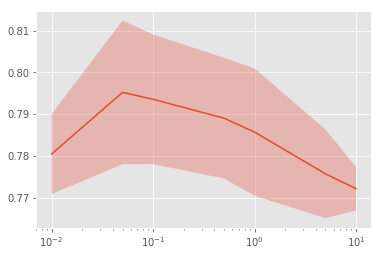

0.8846286151969125


In [18]:
print ('Метки функции предсказаний:\n')
print (y_test[:10])
print (optimizer_zeros.predict(X_test_zeros)[:10])
print ('Вероятности(т.к. функция логистическая):\n')
print (optimizer_zeros.predict_proba(X_test_zeros)[:10])
print ('Лучшая функция:\n')
print (optimizer_zeros.best_estimator_)
print ('Коэффициенты лучшей функции:\n')
print (optimizer_zeros.best_estimator_.coef_)
print ('Лучший параметр функции:\n')
print (optimizer_zeros.best_params_)
print ('Ошибка:\n')
print (optimizer_zeros.best_score_)
plot_scores(optimizer_zeros)
auc_zeros=roc_auc_score(y_test, optimizer_zeros.predict_proba(X_test_zeros)[:,1])
print (auc_zeros)

In [19]:
estimator_mean = LogisticRegression(random_state=0)
optimizer_mean = GridSearchCV(estimator_zeros, param_grid = param_grid, cv = cv)
optimizer_mean.fit(X_train_mean, y_train)
optimizer_mean.predict(X_test_mean)

array([1, 0, 0, ..., 0, 0, 0])

Метки функции предсказаний:

4320    0
2006    1
5689    0
472     1
1370    0
1457    1
5783    0
3484    1
1145    0
130     1
Name: Grant.Status, dtype: int64
[1 0 0 1 0 1 0 0 0 1]
Вероятности(т.к. функция логистическая):

[[0.35718115 0.64281885]
 [0.57416916 0.42583084]
 [0.90221414 0.09778586]
 [0.10735504 0.89264496]
 [0.91985266 0.08014734]
 [0.07645625 0.92354375]
 [0.91170657 0.08829343]
 [0.85988267 0.14011733]
 [0.8323369  0.1676631 ]
 [0.26613214 0.73386786]]
Лучшая функция:

LogisticRegression(C=0.05, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=0, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Коэффициенты лучшей функции:

[[ 0.0848126   0.08526772  0.08225478 ...  0.93214145 -0.08613547
   0.08997262]]
Лучший параметр функции:

{'C': 0.05}
Ошибка:

0.795


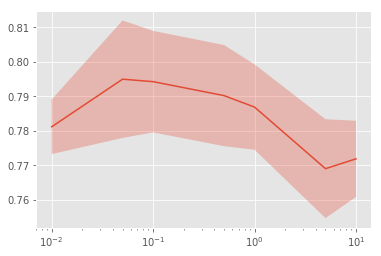

0.8853438280717342


In [20]:
print ('Метки функции предсказаний:\n')
print (y_test[:10])
print (optimizer_mean.predict(X_test_mean)[:10])
print ('Вероятности(т.к. функция логистическая):\n')
print (optimizer_mean.predict_proba(X_test_mean)[:10])
print ('Лучшая функция:\n')
print (optimizer_mean.best_estimator_)
print ('Коэффициенты лучшей функции:\n')
print (optimizer_mean.best_estimator_.coef_)
print ('Лучший параметр функции:\n')
print (optimizer_mean.best_params_)
print ('Ошибка:\n')
print (optimizer_mean.best_score_)
plot_scores(optimizer_mean)
auc_mean=roc_auc_score(y_test, optimizer_mean.predict_proba(X_test_mean)[:,1])
print (auc_mean)

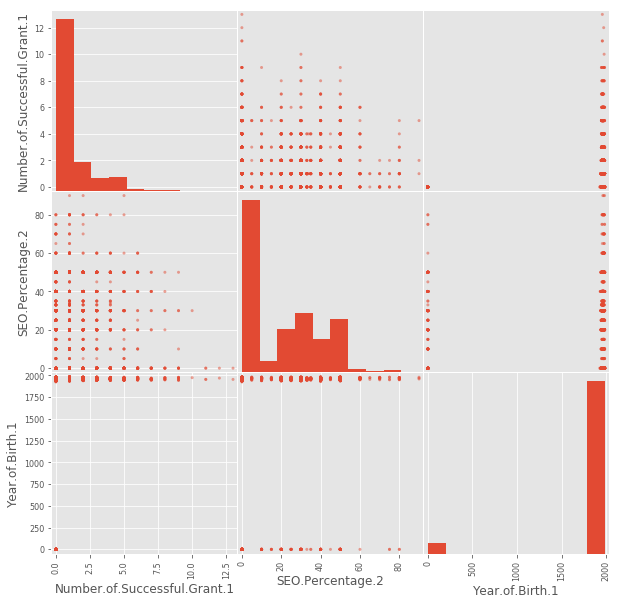

In [21]:
from pandas.tools.plotting import scatter_matrix

data_numeric = pd.DataFrame(X_train_real_zeros, columns=numeric_cols)
list_cols = ['Number.of.Successful.Grant.1', 'SEO.Percentage.2', 'Year.of.Birth.1']
scatter_matrix(data_numeric[list_cols], alpha=0.5, figsize=(10, 10))
plt.show()

In [22]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_real_scaled = scaler.fit_transform(X_train_real_zeros)
X_test_real_scaled = scaler.fit_transform(X_test_real_zeros)

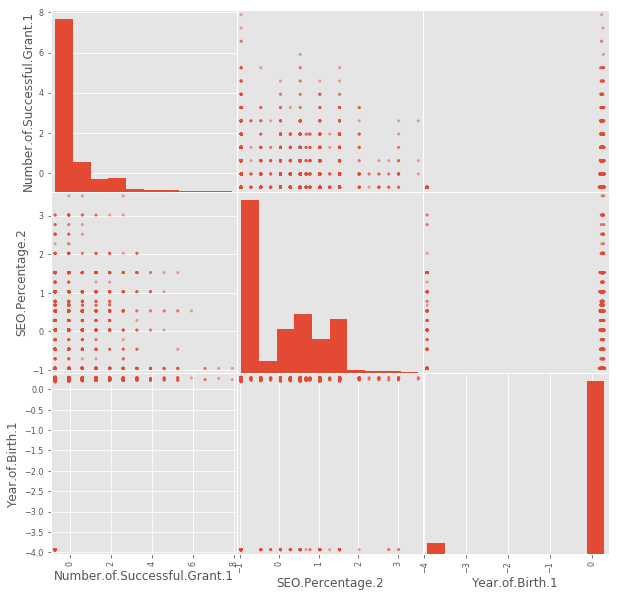

In [23]:
data_numeric_scaled = pd.DataFrame(X_train_real_scaled, columns=numeric_cols)
list_cols = ['Number.of.Successful.Grant.1', 'SEO.Percentage.2', 'Year.of.Birth.1']
scatter_matrix(data_numeric_scaled[list_cols], alpha=0.5, figsize=(10, 10))
plt.show()

In [24]:
X_train_scaler = np.hstack((X_train_real_scaled, X_train_cat_oh))
X_test_scaler = np.hstack((X_test_real_scaled, X_test_cat_oh))

estimator_scaler = LogisticRegression(random_state=0)
optimizer_scaler = GridSearchCV(estimator_scaler, param_grid = param_grid, cv = cv)
optimizer_scaler.fit(X_train_scaler, y_train)
optimizer_scaler.predict(X_test_scaler)

array([1, 0, 0, ..., 0, 0, 0])

Метки функции предсказаний:

4320    0
2006    1
5689    0
472     1
1370    0
1457    1
5783    0
3484    1
1145    0
130     1
Name: Grant.Status, dtype: int64
[1 0 0 1 0 1 0 0 0 1]
Вероятности(т.к. функция логистическая):

[[0.35264573 0.64735427]
 [0.57182947 0.42817053]
 [0.91299747 0.08700253]
 [0.10047526 0.89952474]
 [0.92506054 0.07493946]
 [0.076137   0.923863  ]
 [0.9061877  0.0938123 ]
 [0.85595322 0.14404678]
 [0.82617076 0.17382924]
 [0.26336075 0.73663925]]
Лучшая функция:

LogisticRegression(C=0.05, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=0, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Коэффициенты лучшей функции:

[[ 0.07247474  0.05014383  0.00479832 ...  0.93951782 -0.0470486
   0.1116746 ]]
Лучший параметр функции:

{'C': 0.05}
Ошибка:

0.795


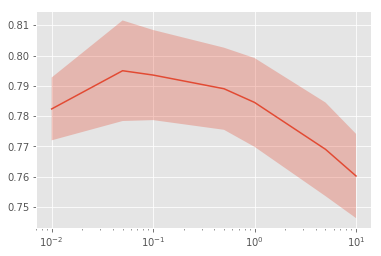

0.884358863628208


In [25]:
print ('Метки функции предсказаний:\n')
print (y_test[:10])
print (optimizer_scaler.predict(X_test_scaler)[:10])
print ('Вероятности(т.к. функция логистическая):\n')
print (optimizer_scaler.predict_proba(X_test_scaler)[:10])
print ('Лучшая функция:\n')
print (optimizer_scaler.best_estimator_)
print ('Коэффициенты лучшей функции:\n')
print (optimizer_scaler.best_estimator_.coef_)
print ('Лучший параметр функции:\n')
print (optimizer_scaler.best_params_)
print ('Ошибка:\n')
print (optimizer_scaler.best_score_)
plot_scores(optimizer_scaler)
auc_scaler=roc_auc_score(y_test, optimizer_scaler.predict_proba(X_test_scaler)[:,1])
print (auc_scaler)

In [26]:
print(np.sum(y_train==0))
print(np.sum(y_train==1))

2316
1884


In [27]:
estimator_scaler_bal = LogisticRegression(random_state=0, class_weight = 'balanced')
optimizer_scaler_bal = GridSearchCV(estimator_scaler_bal, param_grid = param_grid, cv = cv)
optimizer_scaler_bal.fit(X_train_scaler, y_train)
optimizer_scaler_bal.predict(X_test_scaler)

array([1, 0, 0, ..., 0, 0, 0])

0.7885714285714286


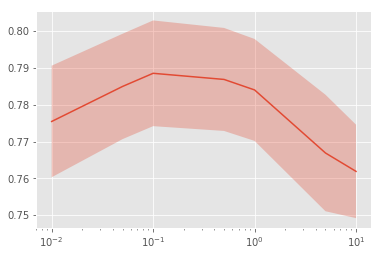

0.8866925859152559


In [28]:
print (optimizer_scaler_bal.best_score_)
plot_scores(optimizer_scaler_bal)
auc_scaler_bal=roc_auc_score(y_test, optimizer_scaler_bal.predict_proba(X_test_scaler)[:,1])
print (auc_scaler_bal)

In [29]:
np.random.seed(0)
indices_to_add = np.random.randint(np.sum(y_train == 1), size=(np.sum(y_train == 0)-np.sum(y_train == 1)))
X_train_to_add = X_train_scaler[y_train.as_matrix() == 1,:][indices_to_add,:]
X_train_balanced = np.vstack((X_train_scaler, X_train_to_add))

y_train_to_add = y_train[y_train == 1][indices_to_add]
y_train_to_add = y_train_to_add.fillna(1)

y_train_balanced = np.hstack((y_train, y_train_to_add))

0.8054835924006909


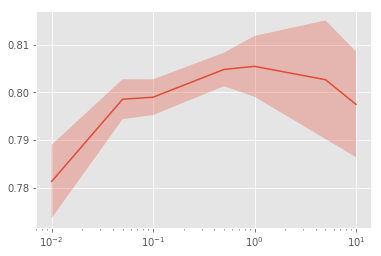

0.883401121820056


In [30]:
optimizer_scaler_bal2 = GridSearchCV(LogisticRegression(random_state=0), param_grid, cv=cv)
optimizer_scaler_bal2.fit(X_train_balanced, y_train_balanced)
print (optimizer_scaler_bal2.best_score_)
plot_scores(optimizer_scaler_bal2)
auc_scaler_bal2=roc_auc_score(y_test, optimizer_scaler_bal2.predict_proba(X_test_scaler)[:,1])
print (auc_scaler_bal2)

In [33]:
(X_train_real_zeros_st, 
 X_test_real_zeros_st, 
 y_train_st, y_test_st) = train_test_split(X_real_zeros, y, 
                                     test_size=0.3, 
                                     random_state=0, stratify=y)
(X_train_cat_oh_st,
 X_test_cat_oh_st) = train_test_split(X_cat_oh, 
                                   test_size=0.3, 
                                   random_state=0, stratify=y)

In [34]:
X_train_real_st_scaled = scaler.fit_transform(X_train_real_zeros_st)
X_test_real_st_scaled = scaler.fit_transform(X_test_real_zeros_st)
X_train_st = np.hstack((X_train_real_st_scaled, X_train_cat_oh_st))
X_test_st = np.hstack((X_test_real_st_scaled, X_test_cat_oh_st))

In [35]:
optimizer_st = GridSearchCV(LogisticRegression(random_state = 0, class_weight = 'balanced'), param_grid, cv=cv)
optimizer_st.fit(X_train_st, y_train_st)

GridSearchCV(cv=3, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=0,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': [0.01, 0.05, 0.1, 0.5, 1, 5, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

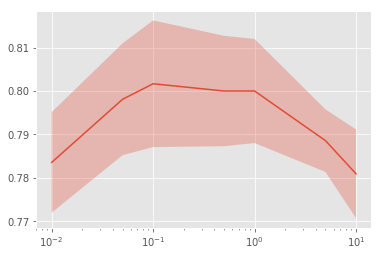

0.8016666666666666
0.8794071768692251


In [36]:
plot_scores(optimizer_st)
print(optimizer_st.best_score_)
auc_st = roc_auc_score(y_test_st, optimizer_st.best_estimator_.predict_proba(X_test_st)[:,1])
print(auc_st)

In [38]:
from sklearn.preprocessing import PolynomialFeatures

In [41]:
transform = PolynomialFeatures(3)
X_train_real_poly = transform.fit_transform(X_train_real_zeros_st)
X_test_real_poly = transform.transform(X_test_real_zeros_st)

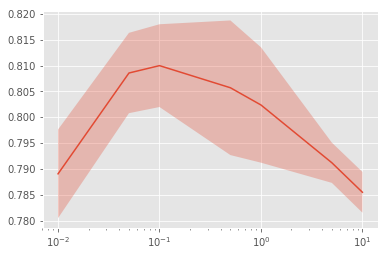

0.81


In [42]:
X_train_real_poly_scaled = scaler.fit_transform(X_train_real_poly)
X_test_real_poly_scaled = scaler.fit_transform(X_test_real_poly)

X_train_poly = np.hstack((X_train_real_poly_scaled, X_train_cat_oh_st))
X_test_poly = np.hstack((X_test_real_poly_scaled, X_test_cat_oh_st))

optimizer_poly = GridSearchCV(LogisticRegression(random_state = 0, fit_intercept=False), param_grid, cv=cv)
optimizer_poly.fit(X_train_poly, y_train_st)
plot_scores(optimizer_poly)
print(optimizer_poly.best_score_)
auc_poly = roc_auc_score(y_test_st, optimizer_poly.predict_proba(X_test_poly)[:,1])

In [43]:
print(auc_poly)

0.8908474268455907


In [44]:
(X_train_real_zeros_st, 
 X_test_real_zeros_st, 
 y_train_st, y_test_st) = train_test_split(X_real_zeros, y, 
                                     test_size=0.3, 
                                     random_state=0, stratify=y)
(X_train_cat_oh_st,
 X_test_cat_oh_st) = train_test_split(X_cat_oh, 
                                   test_size=0.3, 
                                   random_state=0, stratify=y)
scaler = StandardScaler()

X_train_real_st_scaled = scaler.fit_transform(X_train_real_zeros_st)
X_test_real_st_scaled = scaler.fit_transform(X_test_real_zeros_st)

X_train_st = np.hstack((X_train_real_st_scaled, X_train_cat_oh_st))
X_test_st = np.hstack((X_test_real_st_scaled, X_test_cat_oh_st))

optimizer_lasso = GridSearchCV(LogisticRegression(random_state = 0, penalty='l1', class_weight = 'balanced'), param_grid, cv=cv)
optimizer_lasso.fit(X_train_st, y_train_st)

GridSearchCV(cv=3, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=0,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': [0.01, 0.05, 0.1, 0.5, 1, 5, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [46]:
auc_lasso = roc_auc_score(y_test_st, optimizer_lasso.predict_proba(X_test_st)[:,1])
auc_lasso

0.8768111344966388

In [47]:
num = list()
for i, coef in enumerate(optimizer_lasso.best_estimator_.coef_[0][:X_train_real_st_scaled.shape[1]]):
    print (i, coef)
    if coef == 0:
        num.append(i)
        print (i)

0 0.008938298303063441
1 0.0391103803893587
2 -0.09005706882725176
3 -0.06811113130266974
4 0.0
4
5 -0.004894008670611981
6 0.0
6
7 0.0
7
8 0.02755608415561648
9 -0.007144138880629491
10 0.2327779338204974
11 1.0651434243047013
12 -1.4337627415511405


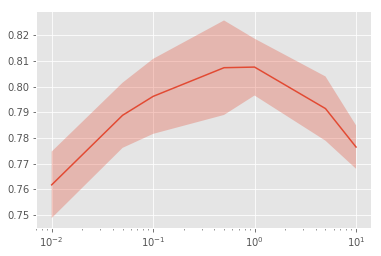

In [48]:
plot_scores(optimizer_lasso)

In [49]:
print (enumerate(optimizer_lasso.best_estimator_.coef_[0][:X_train_real_st_scaled.shape[1]]))